In [55]:
import numpy as np
import pandas as pd
from numpy.linalg import inv, pinv
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from typing import Optional
from matplotlib import pyplot as plt

In [8]:
week1 = pd.read_csv("/home/vxofi/Datasets/Intrusions/week1/week1.csv", sep=";", header=None)
week2 = pd.read_csv("/home/vxofi/Datasets/Intrusions/week2/week2.csv", sep=";", header=None)
week3 = pd.read_csv("/home/vxofi/Datasets/Intrusions/week3/week3.csv", sep=";", header=None)
week4 = pd.read_csv("/home/vxofi/Datasets/Intrusions/week4/week4.csv", sep=";", header=None)
week5 = pd.read_csv("/home/vxofi/Datasets/Intrusions/week5/week5.csv", sep=";", header=None)
week6 = pd.read_csv("/home/vxofi/Datasets/Intrusions/week6/week6.csv", sep=";", header=None)
week7 = pd.read_csv("/home/vxofi/Datasets/Intrusions/week7/week7.csv", sep=";", header=None)
week8_true = pd.read_csv("/home/vxofi/Datasets/Intrusions/week8_true/week8_true.csv", sep=";", header=None)
week9_true = pd.read_csv("/home/vxofi/Datasets/Intrusions/week9_true/week9_true.csv", sep=";", header=None)

In [9]:
week1.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1,06.02.1998,00:00:07,00:00:01,http,2127,80,172.016.114.207,152.163.214.011,0,-
1,2,06.02.1998,00:00:07,00:00:01,http,2139,80,172.016.114.207,152.163.212.172,0,-
2,3,06.02.1998,00:00:07,00:00:01,http,2128,80,172.016.114.207,152.163.214.011,0,-
3,4,06.02.1998,00:00:07,00:00:01,http,2129,80,172.016.114.207,152.163.214.011,0,-
4,5,06.02.1998,00:00:07,00:00:01,http,2130,80,172.016.114.207,152.163.214.011,0,-


In [2]:
train = pd.concat([week1, week2, week3, week4, week5, week6, week7], ignore_index=True)
test = pd.concat([week8_true, week9_true], ignore_index=True)

train.drop(columns=train.columns[0], axis=1,  inplace=True) #train is 1-7 weeks
test.drop(columns=test.columns[0], axis=1,  inplace=True) #test is 8 and 9 weeks as suggested by authors

NameError: name 'week1' is not defined

In [19]:
labels = ["Start Date", "Start Time", "Duration", "Serv", "Src Port",
           "Dest Port", "Src IP", "Dest IP", "Attack Score", "Name"] #from readme
train.columns = labels
test.columns = labels

In [20]:
test.head()

,Start Date,Start Time,Duration,Serv,Src Port,Dest Port,Src IP,Dest IP,Attack Score,Name
0,07/20/1998,08:00:01,00:00:01,domain/u,1114,53,192.168.001.010,172.016.112.020,0,-
1,07/20/1998,08:00:01,00:00:01,domain/u,1059,53,192.168.001.010,172.016.112.020,0,-
2,07/20/1998,08:00:31,00:00:01,snmp/u,1195,161,194.027.251.021,192.168.001.001,0,-
3,07/20/1998,08:00:31,00:00:01,urp/i,-,-,192.168.001.001,194.027.251.021,0,-
4,07/20/1998,08:00:36,00:00:01,snmp/u,1197,161,194.027.251.021,192.168.001.001,0,-


New Dataset

In [56]:
train = pd.read_csv("/home/vxofi/Datasets/KDD-CUP/kdd_train.csv", sep=",")
test = pd.read_csv("/home/vxofi/Datasets/KDD-CUP/kdd_test.csv", sep=",")

In [57]:
data = pd.concat([train, test], ignore_index=True)
X = pd.get_dummies(data.iloc[:, :-1], columns=['protocol_type', 'service', 'flag'], dtype=int)
y = pd.get_dummies(data['labels'], dtype=int)

# paper says, they use 2000/4000/8000 random connections from dataset

# Extract the sampled records from X and Y datasets
sampled_X = X.sample(n=8000, random_state=42)
sampled_y = y.loc[sampled_X.index]

sampled_y_bin = (sampled_y['normal'] == 1).astype(int) # 1 is attack, 0 is normal
# train test split
#scaling

In [58]:
scaler = StandardScaler()

# then they split train and test equally
X_train = sampled_X[:4000]
onhs_tr = X_train.loc[:, "protocol_type_icmp":]
X_train = scaler.fit_transform(X_train.loc[:, :"dst_host_srv_rerror_rate"])
X_train = np.concatenate([X_train, onhs_tr.to_numpy()], axis=1)

X_test = sampled_X[4000:]
onhs_te = X_test.loc[:, "protocol_type_icmp":]
X_test = scaler.fit_transform(X_test.loc[:, :"dst_host_srv_rerror_rate"])
X_test = np.concatenate([X_test, onhs_te.to_numpy()], axis=1)

y_train = sampled_y[:4000]
y_train_bin = sampled_y_bin[:4000]
y_train = np.argmax(y_train, axis=1)

y_test = sampled_y[4000:]
y_test_bin = sampled_y_bin[4000:]
y_test = np.argmax(y_test, axis=1)

In [60]:
class ELM(BaseEstimator, ClassifierMixin):
    def __init__(self, num_input_nodes : int=None, num_hidden_units : int=None,
                 num_out_units : int=None, C : float=None,
                 beta_init : np.ndarray = None,
                 w_init : np.ndarray = None,
                 bias_init : np.ndarray = None):
        self.num_input_nodes = num_input_nodes
        self.num_hidden_units = num_hidden_units
        self.num_out_units = num_out_units
        self.C = C

        if isinstance(beta_init, np.ndarray):
            self._beta = beta_init
        else:
            self._beta = np.random.uniform(-1., 1., size=(self.num_hidden_units, self.num_out_units))

        if isinstance(w_init, np.ndarray):
            self._w = w_init
        else:
            self._w = np.random.uniform(-1, 1, size=(self.num_input_nodes, self.num_hidden_units))

        if isinstance(bias_init, np.ndarray):
            self._bias = bias_init
        else:
            self._bias = np.zeros(shape=(self.num_hidden_units,))

    def _sigmoid(self, x : float) ->  float:
        return 1. / (1. + np.exp(-x))

    def fit(self, X : np.ndarray, Y : np.ndarray) -> None:
        self.classes_ = unique_labels(Y)
        
        H = self._sigmoid(X.dot(self._w) + self._bias)
        I = np.eye(self.num_hidden_units)
        
        label_mapping = {cls: i for i, cls in enumerate(self.classes_)}
        Y_mapped = np.array([label_mapping[label] for label in Y])

        # Convert labels to one-hot encoding
        Y_onehot = np.zeros((Y.shape[0], self.classes_.shape[0]))
        Y_onehot[np.arange(Y.shape[0]), Y_mapped] = 1
        
        self._beta = np.linalg.inv((H.T @ H) + (self.C * I)) @ H.T @ Y_onehot


    def predict_proba(self, X : np.ndarray) -> np.ndarray:
        H = self._sigmoid(X.dot(self._w) + self._bias)
        preds = H.dot(self._beta)
        
        if self.num_out_units == 1:
        # For binary classification, use sigmoid function
            y_pred_proba = 1 / (1 + np.exp(-preds))
        else:
        # For multi-class classification, use softmax function
            exp_pred = np.exp(preds - np.max(preds, axis=1, keepdims=True))
            y_pred_proba = exp_pred / np.sum(exp_pred, axis=1, keepdims=True)

        return y_pred_proba
    
    def predict(self, X : np.ndarray) -> np.ndarray:
        y_pred_proba = self.predict_proba(X)
        y_pred_indices = np.argmax(y_pred_proba, axis=1)
        y_pred = self.classes_[y_pred_indices]
        return y_pred
    
    def classification_report(self, X : np.ndarray, y_true : np.ndarray) -> str:
        y_pred = self.predict(X)
        return classification_report(y_true, y_pred)
    
    def get_params(self, deep=True):
        return {
            'num_out_units': self.num_out_units,
            'num_hidden_units': self.num_hidden_units,
            'num_out_units': self.num_out_units,
            'C': self.C
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [61]:
class KELM(BaseEstimator, ClassifierMixin):
    def __init__(self, num_out_units : int=None, C : float=None, gamma : float=None):
        self.num_out_units = num_out_units
        self.C = C
        self.gamma = gamma
        self._beta = None

    def _cal_K(self, X : np.ndarray, Y : np.ndarray) -> np.ndarray:
        if self.gamma is None:
            self.gamma = 1.0 / X.shape[1]  # Default gamma value
        # Compute the RBF kernel matrix
        X_norm = np.sum(X ** 2, axis=-1)
        Y_norm = np.sum(Y ** 2, axis=-1)
        K = np.exp(-self.gamma * (X_norm[:, None] + Y_norm[None, :] - 2 * np.dot(X, Y.T)))
        return K
    
    def fit(self, X : np.ndarray, Y : np.ndarray) -> None:
        self.classes_ = unique_labels(Y)
        self._X_train = X
        if self.C is None: # Default C value
            self.C = 1.0
        K = self._cal_K(X, X)  # Kernel matrix for training data
        reg_term = np.eye(K.shape[0]) / self.C

        # Map labels to contiguous integers starting from 0
        label_mapping = {cls: i for i, cls in enumerate(self.classes_)}
        Y_mapped = np.array([label_mapping[label] for label in Y])

        # Convert labels to one-hot encoding
        Y_onehot = np.zeros((Y.shape[0], self.classes_.shape[0]))
        Y_onehot[np.arange(Y.shape[0]), Y_mapped] = 1

        # Compute the output weights beta
        self._beta = np.linalg.solve(K + reg_term, Y_onehot)
        #self._beta = np.linalg.solve(K + reg_term, Y)

    def predict_proba(self, X : np.ndarray) -> np.ndarray:
        K = self._cal_K(X, self._X_train)  # Kernel matrix between new data and training data
        preds = np.dot(K, self._beta)
        
        if self.num_out_units == 1:
        # For binary classification, use sigmoid function
            y_pred_proba = 1 / (1 + np.exp(-preds))
        else:
        # For multi-class classification, use softmax function
            exp_pred = np.exp(preds - np.max(preds, axis=1, keepdims=True))
            y_pred_proba = exp_pred / np.sum(exp_pred, axis=1, keepdims=True)

        return y_pred_proba
    
    def predict(self, X : np.ndarray) -> np.ndarray:
        y_pred_proba = self.predict_proba(X)
        y_pred_indices = np.argmax(y_pred_proba, axis=1)
        y_pred = self.classes_[y_pred_indices]
        return y_pred
    
    def classification_report(self, X : np.ndarray, y_true : np.ndarray) -> str:
        y_pred = self.predict(X)
        return classification_report(y_true, y_pred)
    
    def get_params(self, deep=True):
        return {
            'num_out_units': self.num_out_units,
            'C': self.C,
            'gamma': self.gamma
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [63]:
test = KELM(2, 2, 2)
test.fit(X_train, y_train_bin)

In [51]:
Cs = [2**i for i in range(-24, 25 + 1)]
gs = [2**i for i in range(-24, 2 + 1)]

param_grid_SVC = [
  {'C': Cs, 'gamma': gs, 'kernel': ['rbf']},
 ]
param_grid_KELM_bin = [
  {'num_out_units': [2], 'C': Cs, 'gamma': gs},
 ]
param_grid_KELM = [
  {'num_out_units': [37], 'C': Cs, 'gamma': gs},
 ]

In [96]:
#SVM for binary classification
grid_SVC_bin = GridSearchCV(SVC(), param_grid_SVC, cv=10, verbose=1, n_jobs=8) # cv=10 as in other* paper
grid_SVC_bin.fit(X_train, y_train_bin)
C, g, ker = grid_SVC_bin.best_params_.values()
SVM_classifier = SVC(kernel=ker, C=C, gamma=g)
print("best params: ", grid_SVC_bin.best_params_.values())
# best params:  dict_values([64, 0.03125, 'rbf'])

Fitting 10 folds for each of 2500 candidates, totalling 25000 fits


KeyboardInterrupt: 

In [ ]:
#SVM for multi label classification
grid_SVC = GridSearchCV(OneVsOneClassifier(SVC()), param_grid_SVC, cv=10, verbose=5, n_jobs=8)
grid_SVC.fit(X_train, y_train)
C, g, ker = grid_SVC.best_params_.values()
SVM_multic = OneVsOneClassifier(SVC(kernel=ker, C=C, gamma=g))
print("best params: ", grid_SVC.best_params_.values())

In [9]:
#KELM for binary classification
grid_KELM_bin = GridSearchCV(KELM(), param_grid_KELM_bin,
                             cv=10, verbose=2, n_jobs=1, scoring='accuracy') # n_jobs > 5 is crash
grid_KELM_bin.fit(X_train, y_train_bin) # well i dont have enough memory
no, C, g = grid_KELM_bin.best_params_.values()
ELM_kernel_bic = KELM(num_out_units=no, C=C, gamma=g)
print("best params: ", grid_KELM_bin.best_params_.values())

Fitting 10 folds for each of 2500 candidates, totalling 25000 fits
[CV] END C=5.960464477539063e-08, gamma=5.960464477539063e-08, num_out_units=2; total time=   3.2s
[CV] END C=5.960464477539063e-08, gamma=5.960464477539063e-08, num_out_units=2; total time=   2.6s
[CV] END C=5.960464477539063e-08, gamma=5.960464477539063e-08, num_out_units=2; total time=   2.7s
[CV] END C=5.960464477539063e-08, gamma=5.960464477539063e-08, num_out_units=2; total time=   3.7s
[CV] END C=5.960464477539063e-08, gamma=5.960464477539063e-08, num_out_units=2; total time=   3.3s
[CV] END C=5.960464477539063e-08, gamma=5.960464477539063e-08, num_out_units=2; total time=   2.3s
[CV] END C=5.960464477539063e-08, gamma=5.960464477539063e-08, num_out_units=2; total time=   2.9s
[CV] END C=5.960464477539063e-08, gamma=5.960464477539063e-08, num_out_units=2; total time=   2.4s
[CV] END C=5.960464477539063e-08, gamma=5.960464477539063e-08, num_out_units=2; total time=   2.3s
[CV] END C=5.960464477539063e-08, gamma=5.

KeyboardInterrupt: 

In [10]:
#KELM for multi class classification
grid_KELM = GridSearchCV(KELM(), param_grid_KELM, cv=10, verbose=5, n_jobs=1)
grid_KELM.fit(X_train, y_train)
no, C, g = grid_KELM.best_params_.values()
ELM_kernel_multic = KELM(no, param_C=C, gamma=g)
print("best params: ", grid_KELM.best_params_.values())

Fitting 10 folds for each of 2500 candidates, totalling 25000 fits


/home/vxofi/.cache/pypoetry/virtualenvs/elmforid-_YaLGIda-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[CV 1/10] END C=5.960464477539063e-08, gamma=5.960464477539063e-08, num_out_units=37;, score=0.003 total time=  20.5s
[CV 2/10] END C=5.960464477539063e-08, gamma=5.960464477539063e-08, num_out_units=37;, score=0.003 total time=  19.3s
[CV 3/10] END C=5.960464477539063e-08, gamma=5.960464477539063e-08, num_out_units=37;, score=0.003 total time=  20.2s


KeyboardInterrupt: 

In [37]:
test = KELM(37, 0.0625, 0.05)
# Best params bin:  {'num_out_units': 2, 'gamma': 0.015625, 'C': 1024}
# Best params:  {'num_out_units': 37, 'gamma': 0.5, 'C': 4}
test.fit(X_train, y_train)
preds = test.predict(X_test)
accuracy_score(y_test, preds)

0.948

In [38]:
accuracy_score(y_train, test.predict(X_train))

0.951

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/home/vxofi/.cache/pypoetry/virtualenvs/elmforid-_YaLGIda-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[CV] END C=0.0009765625, gamma=3.814697265625e-06, num_out_units=37; total time=  10.3s
[CV] END C=0.0009765625, gamma=3.814697265625e-06, num_out_units=37; total time=  11.7s
[CV] END C=0.0009765625, gamma=3.814697265625e-06, num_out_units=37; total time=  12.2s
[CV] END C=0.0009765625, gamma=3.814697265625e-06, num_out_units=37; total time=  12.3s
[CV] END C=0.0009765625, gamma=3.814697265625e-06, num_out_units=37; total time=  15.8s
[CV] END C=0.0009765625, gamma=3.814697265625e-06, num_out_units=37; total time=  14.7s
[CV] END C=0.0009765625, gamma=3.814697265625e-06, num_out_units=37; total time=  14.9s
[CV] END C=0.0009765625, gamma=3.814697265625e-06, num_out_units=37; total time=  15.8s
[CV] END C=0.0009765625, gamma=3.814697265625e-06, num_out_units=37; total time=   2.9s
[CV] END C=0.0009765625, gamma=3.814697265625e-06, num_out_units=37; total time=   3.0s
[CV] END C=1048576, gamma=1.9073486328125e-06, num_out_units=37; total time=   2.9s
[CV] END C=1048576, gamma=1.90734863

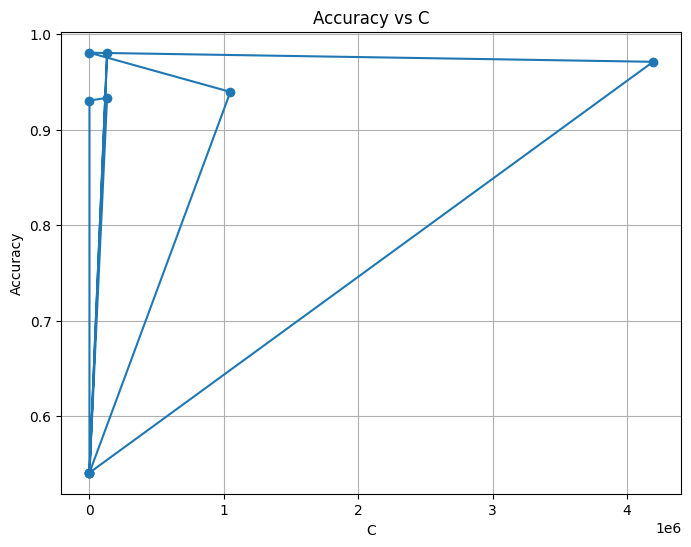

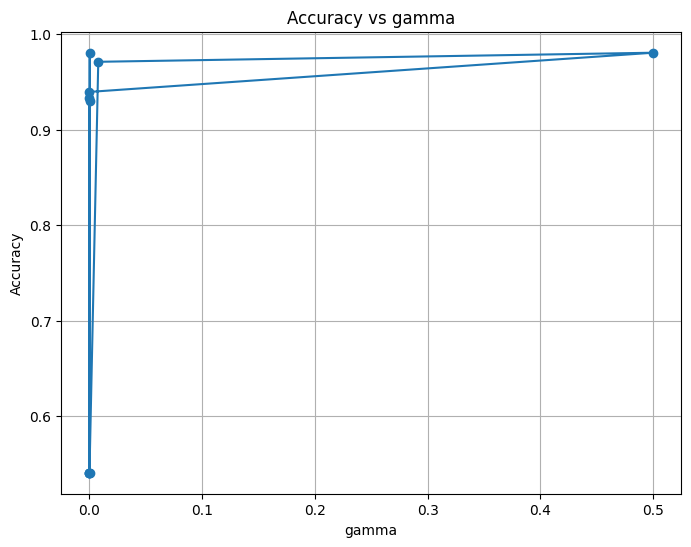

In [52]:
random_KELM = RandomizedSearchCV(KELM(), param_distributions=param_grid_KELM, n_iter=10, cv=10, verbose=2, n_jobs=4)
random_KELM.fit(X_train, y_train)

# Get the best parameters
no, C, g = random_KELM.best_params_.values()
print("Best params: ", random_KELM.best_params_)

# Create accuracy plots for each hyperparameter
hyperparameters = ['C', 'gamma']
for param in hyperparameters:
    # Get the values and corresponding mean test scores for the current hyperparameter
    param_values = [params[param] for params in random_KELM.cv_results_['params']]
    mean_test_scores = random_KELM.cv_results_['mean_test_score']
    
    # Plot the accuracy scores against the hyperparameter values
    plt.figure(figsize=(8, 6))
    plt.plot(param_values, mean_test_scores, 'o-')
    plt.xlabel(param)
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs {param}')
    plt.grid(True)
    plt.show()


In [2]:
ELM_basic_bic = ELM(41, 2, 400, param_C=2)
ELM_basic_multic = ELM(41, 23, 400, param_C=2) #paper uses C=2 for basic ELM

#ELM_kernel_bic = KELM(41, 2, param_C=C, gamma=g)
#ELM_kernel_multic = KELM(41, 23, param_C=C, gamma=g)

# SVM_classifier = SVC(kernel='rbf', C=C, gamma=g)
#SVM_multic = OneVsOneClassifier(SVC(kernel='rbf', C=C, gamma=g))

NameError: name 'ELM' is not defined